# 光伏材料筛选
**大规模筛选**
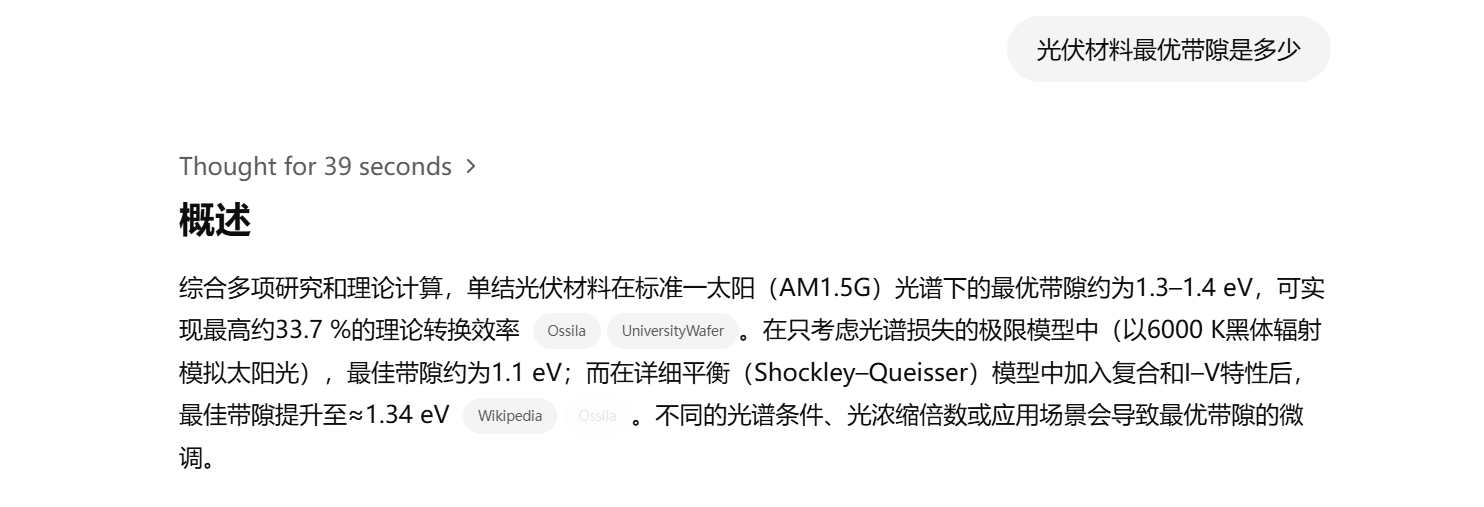

筛选带隙范围在**1.34eV**左右的二元与四元材料

## 模型训练
使用全部数据训练模型

In [20]:
# import libraries
import os
import sys
import itertools
import numpy as np
import pandas as pd
# Set random seed for reproducibility
RANDOM_SEED = 42

In [21]:
current_path = os.getcwd()
current_path
# To import the custom module from a specific path
sys.path.insert(0, os.path.join(current_path))
from Utools.SingleModel import SingleModel
from xgboost import XGBRegressor
from pymatgen.core import Element, Composition
from matminer.featurizers.conversions import StrToComposition
from matminer.featurizers.composition import ElementProperty

In [22]:
# load data
# Load data
file_dir = os.path.join(current_path, './Data')
# dft data
dft_train = pd.read_csv(os.path.join(file_dir, 'rfe_train_data', 'mp_train_set.csv'))
dft_test = pd.read_csv(os.path.join(file_dir, 'rfe_test_data', 'mp_test_set.csv'))
dft_train = pd.concat([dft_train, dft_test], axis=0, ignore_index=True)
dft_train.shape

(9832, 119)

In [23]:
dft_train_X = dft_train.drop(columns=['composition', 'band_gap'])
dft_train_y = dft_train['band_gap']

In [24]:
xgboost = XGBRegressor(learning_rate=0.1, max_depth=7, n_estimators=500,
    colsample_bytree=0.7, subsample=1.0, reg_lambda=1.0, alpha=0.5, 
    objective='reg:squarederror', random_state=RANDOM_SEED, n_jobs=-1)
model = SingleModel(model=xgboost)
model.train(dft_train_X, dft_train_y)

Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   6.5s
Model training completed!


## 生成材料

In [25]:
# Define the pool of elements to combine (Adjust as needed)
# Example: Common elements in semiconductors
element_pool = [Element(sym) for sym in ['Cu', 'Ag', 'Au', 'Zn', 'Cd', 'Hg', 'Al', 'Ga', 'In', 'Tl', 'Ge', 'Sn', 'Pb', 'P', 'As', 'Sb', 'Bi', 'Te', 'Se', 'S', 'O']]
all_candidate_comps = []

# Generate binary combinations (A, B)
for combo in itertools.combinations(element_pool, 2):
    # Create equimolar composition for simplicity, e.g., AB
    comp_dict = {el.symbol: 1 for el in combo}
    all_candidate_comps.append(Composition(comp_dict))

# Generate ternary combinations (A, B, C)
for combo in itertools.combinations(element_pool, 3):
    # Create equimolar composition, e.g., ABC
    comp_dict = {el.symbol: 1 for el in combo}
    all_candidate_comps.append(Composition(comp_dict))

# Generate quaternary combinations (A, B, C, D)
for combo in itertools.combinations(element_pool, 4):
    # Create equimolar composition, e.g., ABCD
    comp_dict = {el.symbol: 1 for el in combo}
    all_candidate_comps.append(Composition(comp_dict))

print(f"Generated {len(all_candidate_comps)} candidate compositions.")

Generated 7525 candidate compositions.


In [26]:
pre_df = pd.DataFrame(columns=['composition', 'band_gap'])
pre_df['composition'] = [comp for comp in all_candidate_comps]
features=["Number","AtomicRadius","AtomicVolume","AtomicWeight","MolarVolume","SpaceGroupNumber","CovalentRadius","Density",
          "Column","Electronegativity","ElectronAffinity","FirstIonizationEnergy",
          "DipolePolarizability","Polarizability","BoilingT","MeltingT","ThermalConductivity","LogThermalConductivity",
          "HeatVaporization","HeatFusion","FusionEnthalpy","GSbandgap","GSenergy_pa","GSestBCClatcnt","GSestFCClatcnt","GSvolume_pa",
          "GSmagmom","NUnfilled","NValence","NdUnfilled","NdValence","NfUnfilled","NfValence","NpUnfilled","NpValence","NsUnfilled",
          "NsValence","ZungerPP-r_sigma"]
stats = ["minimum", "maximum", "mean", "avg_dev", "range", "mode"] 

featurizer = ElementProperty(data_source='magpie', features=features, stats=stats) 	
featurized_df = featurizer.featurize_dataframe(pre_df, col_id='composition')
# 将列名去掉MagpieData
featurized_df.columns = featurized_df.columns.str.replace('MagpieData ', '')
featurized_df = featurized_df[dft_train.columns]

e:\software2\Anaconda\Lib\site-packages\matminer\utils\data.py:326: UserWarning: MagpieData(impute_nan=False):
In a future release, impute_nan will be set to True by default.
                    This means that features that are missing or are NaNs for elements
                    from the data source will be replaced by the average of that value
                    over the available elements.
                    This avoids NaNs after featurization that are often replaced by
                    dataset-dependent averages.
  warnings.warn(f"{self.__class__.__name__}(impute_nan=False):\n" + IMPUTE_NAN_WARNING)


ElementProperty:   0%|          | 0/7525 [00:00<?, ?it/s]

In [27]:
featurized_df.head()

,composition,band_gap,maximum Number,mean Number,avg_dev Number,range Number,mean AtomicRadius,avg_dev AtomicRadius,minimum AtomicVolume,mean AtomicVolume,...,range NfUnfilled,mean NpUnfilled,avg_dev NpUnfilled,mean NpValence,avg_dev NpValence,avg_dev NsValence,maximum ZungerPP-r_sigma,mean ZungerPP-r_sigma,avg_dev ZungerPP-r_sigma,range ZungerPP-r_sigma
0,"(Cu, Ag)",NaN,47.0,38.0,9.0,18.0,1.475,0.125,11.829942,14.452795,...,0.0,0.0,0.0,0.0,0.0,0.0,2.375,2.2075,0.1675,0.335
1,"(Cu, Au)",NaN,79.0,54.0,25.0,50.0,1.350,0.000,11.829942,14.388503,...,0.0,0.0,0.0,0.0,0.0,0.0,2.660,2.3500,0.3100,0.620
2,"(Cu, Zn)",NaN,30.0,29.5,0.5,1.0,1.350,0.000,11.829942,13.517813,...,0.0,0.0,0.0,0.0,0.0,0.5,2.040,1.9600,0.0800,0.160
3,"(Cu, Cd)",NaN,48.0,38.5,9.5,19.0,1.450,0.100,11.829942,16.704984,...,0.0,0.0,0.0,0.0,0.0,0.5,2.215,2.1275,0.0875,0.175
4,"(Cu, Hg)",NaN,80.0,54.5,25.5,51.0,1.425,0.075,11.829942,18.220842,...,0.0,0.0,0.0,0.0,0.0,0.5,2.410,2.2250,0.1850,0.370


In [28]:
## 带隙预测
pre_df['band_gap'] = model.predict(featurized_df.drop(columns=['composition', 'band_gap']))
pre_df.head()

,composition,band_gap
0,"(Cu, Ag)",0.133671
1,"(Cu, Au)",0.394189
2,"(Cu, Zn)",-0.080415
3,"(Cu, Cd)",-0.103320
4,"(Cu, Hg)",0.300439


In [62]:
# --- Filtering ---
# Filter for materials with predicted band gap around 1.34 eV (e.g., 1.2 eV to 1.5 eV)
target_bg = 1.34
up_tolerance = 0.06 # Adjust tolerance as needed (1.34 +/- 0.16 -> 1.18 to 1.50)
down_tolerance = 0.12
filtered_df = pre_df[(pre_df['band_gap'] >= target_bg - down_tolerance) & (pre_df['band_gap'] <= target_bg + up_tolerance)]
filtered_df = filtered_df.reset_index(drop=True)    
filtered_df.shape

(553, 2)

In [63]:
filtered_df['formula'] = filtered_df['composition'].apply(lambda x: str(x))

In [64]:
filtered_df

,composition,band_gap,formula
0,"(Al, Sb)",1.223385,Al1 Sb1
1,"(Tl, O)",1.315197,Tl1 O1
2,"(Ge, S)",1.255892,Ge1 S1
3,"(As, Se)",1.391558,As1 Se1
4,"(Te, S)",1.379758,Te1 S1
...,...,...,...
548,"(Sb, Bi, Se, S)",1.220388,Sb1 Bi1 Se1 S1
549,"(Sb, Bi, Se, O)",1.257346,Sb1 Bi1 Se1 O1
550,"(Sb, Te, Se, S)",1.317065,Sb1 Te1 Se1 S1
551,"(Sb, Te, Se, O)",1.353451,Sb1 Te1 Se1 O1


In [65]:
# 光伏电池常用材料：
used_formula = ['Ga1 As1', 'Ga1 Al1 As1', 'In1 P1', 'Cd1 S1', 'Cd1 Te1']

In [66]:
filtered_df['formula'].isin(used_formula).sum()

np.int64(0)

In [58]:
pre_df[pre_df['composition'] == Composition('Cd1 Te1')]

,composition,band_gap
86,"(Cd, Te)",0.632047
